# 📊 Tutorial: CGM Data Analysis with JupyterHealth

Welcome to the **Continuous Glucose Monitoring (CGM)** tutorial on the **JupyterHealth** platform.  
This notebook walks you through:
- 📥 Getting patient and study information from JupyterHealth Exchange
- 📥 Loading CGM data from JupyterHealth Exchange
- 🧮 Calculating core AGP (Ambulatory Glucose Profile) metrics
- 📊 Visualizing glucose trends for researchers or clinicians

---


## 🔗 Step 1: Connect to JupyterHealth Exchange and Explore

We use the `jupyterhealth-client` package to securely pull CGM data from a trusted JupyterHealth Data Exchange.

In [1]:
from enum import Enum

import cgmquantify
import pandas as pd
from jupyterhealth_client import Code, JupyterHealthClient

CGM = Code.BLOOD_GLUCOSE

pd.options.mode.chained_assignment = None

jh_client = JupyterHealthClient()

```{note}
By default, `JupyterHealthClient` loads credentials from environment variables `$JHE_URL` and `$JHE_TOKEN`.

You can also pass these as `JupyterHealthClient(url='...', token='...')`, if they don't come from your environment.
```

### - 🏥 First, list available organizations

JupyterHealth Exchange organizes data access and patients are associated with organizations,
which may be in a hierarchy of institutions, departments, teams, etc.

In [2]:
# construct a dict of all organizations
org_dict = {org['id']: org for org in jh_client.list_organizations()}
# populate a tree of children, from each organization's `partOf` reference to its parent
# the root org has id=0

for org in org_dict.values():
    parent_id = org['partOf']
    if parent_id is not None:
        parent = org_dict[parent_id]
        parent.setdefault("child_ids", []).append(org['id'])
    

In [3]:
def print_org(org, indent=''):
    print(f"{indent}[{org['id']}] {org['name']}")
    for org_id in org.get('child_ids', []):
        print_org(org_dict[org_id], indent=" " * len(indent) + " ⮑")


for org_id in org_dict[0]['child_ids']:
    print_org(org_dict[org_id])

[20011] University of Example
 ⮑[20027] ACME
 ⮑[20013] Example Institute for Tutorials
 ⮑[20026] Cardiology Department
 ⮑[20024] JupyterHub users
[20001] U of X
 ⮑[20019] East Campus


### -🧍🏾‍♀️📋🧍🏻‍♂️Second, list available studies and patients

A `study` is associated with an organization and specific data requests.

Practitioners have access to specific studies, e.g. via their organization membership.

All my studies:

In [4]:
for study in jh_client.list_studies():
    print(f"  - [{study['id']}] {study['name']} org:{study['organization']['name']}")

  - [30012] CGM & Metabolic Health Study org:Example Institute for Tutorials
  - [30010] Health Connect CGM Integration org:Cardiology Department
  - [30013] iHealth Blood Pressure Study org:Cardiology Department
  - [30006] Remote Monitoring demo org:East Campus
  - [30011] Sample Data org:Example Institute for Tutorials


I'm interested in the 'Sample Data' study, with id 30011.

_I'm interested in it because it's the one with fake patients and sample data from https://doi.org/10.1371/journal.pbio.2005143.s010 so I can include the output in these docs_.

In [5]:
study_id = 30011
study = jh_client.get_study(study_id)
study

{'id': 30011,
 'name': 'Sample Data',
 'description': 'To explore the Exchange capabilities. This study should only contain synthetic patients and already published or synthetic Observations.',
 'organization': {'id': 20013,
  'name': 'Example Institute for Tutorials',
  'type': 'edu'}}

#### Reviewing patients in the study

We can review which patients are in the study, and which are invited to the study but haven't consented to data availability via the **patient consents** endpoint:

In [6]:
from dateutil.parser import parse as parse_date

# show all the patients with study data I have access to:
print(f"Patients in study [{study['id']}] {study['name']}")

for patient in jh_client.list_patients():
    consents = jh_client.get_patient_consents(patient['id'])
    consented = {
        _study['id']: _study
        for _study in consents['studies']
    }
    pending_consent = {
        _study['id']: _study
        for _study in consents['studiesPendingConsent']
    }
    if study_id not in consented and study_id not in pending_consent:
        # ignore patients not in the study
        continue
    print(f"[{patient['id']}] {patient['nameFamily']}, {patient['nameGiven']}: {patient['telecomEmail']}")
    if study_id in consented:
        study_consent = consented[study_id]
        for scope_consent in study_consent['scopeConsents']:
            date = parse_date(scope_consent['consentedTime']).date()
            print(f" - {scope_consent['code']['text']}, consented {date}")
    if study_id in pending_consent:
        study_pending_consent = pending_consent[study_id]
        for scope_consent in study_pending_consent['pendingScopeConsents']:
            print(f" - {scope_consent['code']['text']} (not consented)")


Patients in study [30011] Sample Data
[40001] Patient, Demo: demouser@jupyterhealth.org
 - Blood glucose (not consented)
 - Blood pressure (not consented)
 - Heart Rate (not consented)
[40054] Nguyen, Minh: minh.nguyen@example.com
 - Blood glucose, consented 2025-04-17
 - Blood pressure, consented 2025-04-17
 - Heart Rate, consented 2025-04-17
[40055] Smith, Olivia: olivia.smith@example.com
 - Blood glucose, consented 2025-04-17
 - Blood pressure, consented 2025-04-17
 - Heart Rate, consented 2025-04-17
[40056] Chen, Liang: liang.chen@example.com
 - Blood glucose, consented 2025-04-17
 - Blood pressure, consented 2025-04-17
 - Heart Rate, consented 2025-04-17
[40057] Patel, Anika: anika.patel@example.com
 - Blood glucose, consented 2025-04-17
 - Blood pressure, consented 2025-04-17
 - Heart Rate, consented 2025-04-17
[40058] Garcia, Carlos: carlos.garcia@example.com
 - Blood glucose, consented 2025-04-17
 - Blood pressure, consented 2025-04-17
 - Heart Rate, consented 2025-04-17
[40059

A patient whose data has been requested, but has not consented (there will be no data on this patient):

In [7]:
jh_client.get_patient_consents(40001)

{'patient': {'id': 40001,
  'jheUserId': 10007,
  'identifier': 'demouser-min',
  'nameFamily': 'Patient',
  'nameGiven': 'Demo',
  'birthDate': '1955-01-01',
  'telecomPhone': None,
  'telecomEmail': 'demouser@jupyterhealth.org',
  'organizationId': 20013},
 'consolidatedConsentedScopes': [],
 'studiesPendingConsent': [{'id': 30011,
   'name': 'Sample Data',
   'description': 'To explore the Exchange capabilities. This study should only contain synthetic patients and already published or synthetic Observations.',
   'organization': {'id': 20013,
    'name': 'Example Institute for Tutorials',
    'type': 'edu'},
   'dataSources': [{'id': 70002,
     'name': 'Dexcom',
     'type': 'personal_device',
     'supportedScopes': []},
    {'id': 70001,
     'name': 'iHealth',
     'type': 'personal_device',
     'supportedScopes': []}],
   'pendingScopeConsents': [{'code': {'id': 50001,
      'codingSystem': 'https://w3id.org/openmhealth',
      'codingCode': 'omh:blood-glucose:4.0',
      'te

A sample patient who has consented to share data with this study:

In [8]:
jh_client.get_patient_consents(40054)

{'patient': {'id': 40054,
  'jheUserId': 10040,
  'identifier': '1636-69-001',
  'nameFamily': 'Nguyen',
  'nameGiven': 'Minh',
  'birthDate': '1984-07-11',
  'telecomPhone': '265-642-0143',
  'telecomEmail': 'minh.nguyen@example.com',
  'organizationId': 20013},
 'consolidatedConsentedScopes': [{'id': 50001,
   'codingSystem': 'https://w3id.org/openmhealth',
   'codingCode': 'omh:blood-glucose:4.0',
   'text': 'Blood glucose'},
  {'id': 50002,
   'codingSystem': 'https://w3id.org/openmhealth',
   'codingCode': 'omh:blood-pressure:4.0',
   'text': 'Blood pressure'},
  {'id': 50005,
   'codingSystem': 'https://w3id.org/openmhealth',
   'codingCode': 'omh:heart-rate:2.0',
   'text': 'Heart Rate'}],
 'studiesPendingConsent': [],
 'studies': [{'id': 30011,
   'name': 'Sample Data',
   'description': 'To explore the Exchange capabilities. This study should only contain synthetic patients and already published or synthetic Observations.',
   'organization': {'id': 20013,
    'name': 'Example

## 👩🏻‍🦰 Step 2: Select patient

Select the study patient you are interested in from the information above.

Now we can fetch observations into a pandas DataFrame for the data from this patient and this study.

In [9]:
# pick patient id from above
patient_id = 40072

df = jh_client.list_observations_df(patient_id=patient_id, study_id=study_id, limit=10_000, code=CGM)

df

,resource_type,resourceType,id,meta_lastUpdated,status,subject_reference,code_coding_0_code,code_coding_0_system,modality,schema_id_name,...,external_datasheets_0_datasheet_type,external_datasheets_0_datasheet_reference,source_creation_date_time,blood_glucose_unit,blood_glucose_value,effective_time_frame_date_time,temporal_relationship_to_meal,creation_date_time_local,source_creation_date_time_local,effective_time_frame_date_time_local
0,omh:blood-glucose:4.0,Observation,136676,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-05 12:23:22+00:00,MGDL,129,2024-06-05 12:23:22+00:00,unknown,2024-06-05 12:23:22,2024-06-05 12:23:22,2024-06-05 12:23:22
1,omh:blood-glucose:4.0,Observation,136677,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-05 12:28:22+00:00,MGDL,111,2024-06-05 12:28:22+00:00,unknown,2024-06-05 12:28:22,2024-06-05 12:28:22,2024-06-05 12:28:22
2,omh:blood-glucose:4.0,Observation,136678,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-05 12:33:22+00:00,MGDL,105,2024-06-05 12:33:22+00:00,unknown,2024-06-05 12:33:22,2024-06-05 12:33:22,2024-06-05 12:33:22
3,omh:blood-glucose:4.0,Observation,136679,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-05 12:38:22+00:00,MGDL,102,2024-06-05 12:38:22+00:00,unknown,2024-06-05 12:38:22,2024-06-05 12:38:22,2024-06-05 12:38:22
4,omh:blood-glucose:4.0,Observation,136680,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-05 12:43:22+00:00,MGDL,99,2024-06-05 12:43:22+00:00,unknown,2024-06-05 12:43:22,2024-06-05 12:43:22,2024-06-05 12:43:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008,omh:blood-glucose:4.0,Observation,138684,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-14 13:27:42+00:00,MGDL,108,2024-06-14 13:27:42+00:00,unknown,2024-06-14 13:27:42,2024-06-14 13:27:42,2024-06-14 13:27:42
2009,omh:blood-glucose:4.0,Observation,138685,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-14 13:32:42+00:00,MGDL,110,2024-06-14 13:32:42+00:00,unknown,2024-06-14 13:32:42,2024-06-14 13:32:42,2024-06-14 13:32:42
2010,omh:blood-glucose:4.0,Observation,138686,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-14 13:37:42+00:00,MGDL,105,2024-06-14 13:37:42+00:00,unknown,2024-06-14 13:37:42,2024-06-14 13:37:42,2024-06-14 13:37:42
2011,omh:blood-glucose:4.0,Observation,138687,2025-04-17 16:45:45.625689+00:00,final,Patient/40072,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-06-14 13:42:42+00:00,MGDL,106,2024-06-14 13:42:42+00:00,unknown,2024-06-14 13:42:42,2024-06-14 13:42:42,2024-06-14 13:42:42


We can see a summary of the fields in an Observation if we look at just the first row

In [10]:
df.iloc[0]

resource_type                                           omh:blood-glucose:4.0
resourceType                                                      Observation
id                                                                     136676
meta_lastUpdated                             2025-04-17 16:45:45.625689+00:00
status                                                                  final
subject_reference                                               Patient/40072
code_coding_0_code                                      omh:blood-glucose:4.0
code_coding_0_system                             https://w3id.org/openmhealth
modality                                                        self-reported
schema_id_name                                                  blood-glucose
schema_id_version                                                         3.1
schema_id_namespace                                                       omh
creation_date_time                                  2024-06-05 1

## 🧠 Step 3: Calculate Glucose Metrics

These help us evaluate patient stability and risk zones.

We now compute key statistics to understand the glucose trends:
- **Mean Glucose** $ = \frac{\sum \text{Glucose Readings}}{\text{Total Number of Readings}}$
  
- **Glucose Variability (CV%)** $ = \left( \frac{\text{Standard Deviation of Glucose}}{\text{Mean Glucose}} \right) \times 100$

  
- **Glucose Management Indicator (GMI)** $= 3.31 + 0.02392 \times \text{Mean Glucose}$

- **Time in Range (%)** = $\left( \frac{\text{Number of readings in range of 70-180mg/dL}}{\text{Total number of readings}} \right) \times 100$

Breakdown:
- VLow = Level 2 Hypoglycemia (<54 mg/dL)
- Low = Level 1 Hypoglycemia (54–69 mg/dL)
- **Target Range (70–180 mg/dL)**
- High = Level 1 Hyperglycemia (181–250 mg/dL)
- VHigh = Level 2 Hyperglycemia (>250 mg/dL)


**🧠 Glycemia Risk Index (GRI)**
GRI is a composite metric developed to summarize the overall glycemic risk based on CGM data. It combines both hypoglycemia and hyperglycemia exposure into a single score from 0 to 100, where:

- 0 = Ideal glycemic control (100% Time In Range)
- 100 = Maximum glycemic risk
  
The GRI is computed from the percentage of time spent in four glucose ranges:

**📐 GRI Calculation**

$\text{GRI} = 3.0 \times \text{VLow} + 2.4 \times \text{Low} + 1.6 \times \text{VHigh} + 0.8 \times \text{High}$

GRI is also visualized using a 2D GRI Grid, where:

- X-axis = Hypoglycemia Component = VLow + (0.8 × Low)
- Y-axis = Hyperglycemia Component = VHigh + (0.5 × High)

This allows clinicians to see whether risk is driven more by lows or highs, even if two patients have the same overall GRI.


#### The first block of code:
	1.	✅ Confirms units are in mg/dL.
	2.	🔍 Extracts just CGM glucose values and timestamps.
	3.	🕐 Sorts the glucose values by time for downstream analysis.

In [11]:
# Reduce data to relevant subset for cgm
# make sure we're getting the units we expect
assert (df.blood_glucose_unit == 'MGDL').all()
# reduce data to interesting columns
cgm = df.loc[
    :,
    [
        "blood_glucose_value",
        "effective_time_frame_date_time_local",
    ],
]
# ensure sorted by date
cgm = cgm.sort_values("effective_time_frame_date_time_local")

In [12]:
# Mean of glucose
mean_glucose = cgm["blood_glucose_value"].mean()

# Standard Deviation (SD) of glucose
std_glucose = cgm["blood_glucose_value"].std()

# Coefficient of Variation (CV) = (SD / Mean) * 100
cv_glucose = (std_glucose / mean_glucose) * 100

# Print results
print(f"Mean Glucose: {mean_glucose:.2f} mg/dL")
print(f"Standard Deviation (SD): {std_glucose:.2f} mg/dL")
print(f"Coefficient of Variation (CV): {cv_glucose:.2f}%")

Mean Glucose: 103.92 mg/dL
Standard Deviation (SD): 23.71 mg/dL
Coefficient of Variation (CV): 22.82%


In [13]:
# Compute Glucose Management Indicator (GMI)
gmi = 3.31 + (0.02392 * mean_glucose)

# Print result
print(f"Glucose Management Indicator (GMI): {gmi:.2f}%")

Glucose Management Indicator (GMI): 5.80%


In [14]:
# --- GRI COMPONENTS ---

# Total CGM readings
total_readings = len(cgm)
#print(f"Total CGM Readings: {total_readings}")

# Define time-in-range categories
VLow = (cgm["blood_glucose_value"] < 54).sum() / total_readings * 100
Low = ((cgm["blood_glucose_value"] >= 54) & (cgm["blood_glucose_value"] < 70)).sum() / total_readings * 100
High = ((cgm["blood_glucose_value"] > 180) & (cgm["blood_glucose_value"] <= 250)).sum() / total_readings * 100
VHigh = (cgm["blood_glucose_value"] > 250).sum() / total_readings * 100

# Calculate GRI components
hypo_component = VLow + (0.8 * Low)
hyper_component = VHigh + (0.5 * High)
gri = (3.0 * hypo_component) + (1.6 * hyper_component)
gri = min(gri, 100)  # Cap GRI at 100

# Print results
print("\n--- GRI COMPONENTS ---")
print(f"Level 2 Hypoglycemia (<54 mg/dL): {VLow:.2f}%")
print(f"Level 1 Hypoglycemia (54-69 mg/dL): {Low:.2f}%")
print(f"Level 1 Hyperglycemia (181-250 mg/dL): {High:.2f}%")
print(f"Level 2 Hyperglycemia (>250 mg/dL): {VHigh:.2f}%")
print(f"Hypoglycemia Component: {hypo_component:.2f}%")
print(f"Hyperglycemia Component: {hyper_component:.2f}%")
print(f"Glycemia Risk Index (GRI): {gri:.2f}")


--- GRI COMPONENTS ---
Level 2 Hypoglycemia (<54 mg/dL): 0.15%
Level 1 Hypoglycemia (54-69 mg/dL): 4.07%
Level 1 Hyperglycemia (181-250 mg/dL): 0.70%
Level 2 Hyperglycemia (>250 mg/dL): 0.00%
Hypoglycemia Component: 3.41%
Hyperglycemia Component: 0.35%
Glycemia Risk Index (GRI): 10.78


## 📈 Step 4: Visualize Glucose Patterns

This section generates:
- GRI Grid
- Daily Glucose Profiles
- Ambulatory Glucose Profile (AGP)
- Goals for Type 1 and Type Diabetes

These are vital for interpreting glycemic control and variability.


🟩 **Median Glucose Trend Line**

The green line represents a smoothed median glucose trend for each day.
It is calculated using a rolling window of 5 readings, which helps reduce short-term fluctuations and highlight overall trends in glucose levels.
- ✅ Helps visualize daytime and nighttime patterns
- ✅ Reduces noise from rapid sensor changes
- ⚠️ May slightly lag or flatten sharp spikes or drops

This smoothing approach mimics how continuous glucose monitoring (CGM) systems often display data to enhance clinical interpretation.


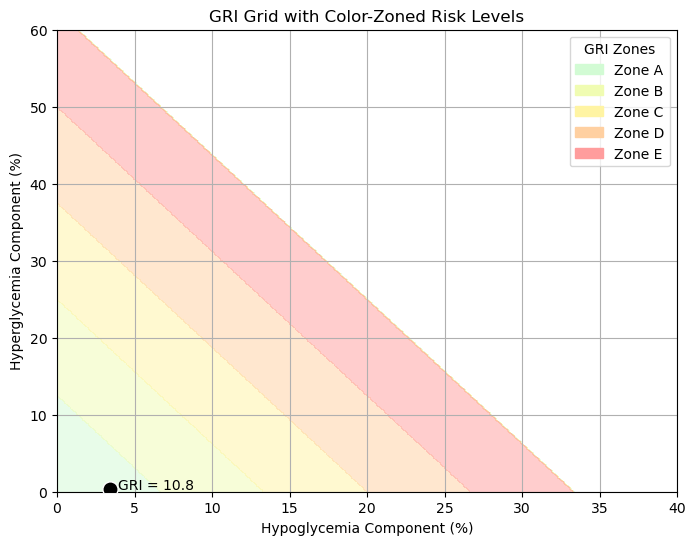

In [15]:
# GRI GRID

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Define the plotting area
fig, ax = plt.subplots(figsize=(8, 6))

# Create a meshgrid for the background
x = np.linspace(0, 40, 400)
y = np.linspace(0, 60, 400)
X, Y = np.meshgrid(x, y)

# Define risk zones: diagonal bands (Zone A to E)
zone = np.zeros_like(X)
zone_bounds = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]

for i, (low, high) in enumerate(zone_bounds):
    mask = (3.0 * X + 1.6 * Y >= low) & (3.0 * X + 1.6 * Y < high)
    zone[mask] = i + 1

# Define zone colors (Zone A to E: green to red)
zone_colors = ['#d2fbd4', '#f0fcb2', '#fff4a3', '#ffd0a1', '#ff9d9d']
zone_labels = ['Zone A', 'Zone B', 'Zone C', 'Zone D', 'Zone E']
zone_cmap = ListedColormap(zone_colors)

# Show background zones
ax.contourf(X, Y, zone, levels=[0.5,1.5,2.5,3.5,4.5,5.5], colors=zone_colors, alpha=0.5)

# Plot GRI point (replace with your values)
hypo_component
hyper_component
gri

ax.scatter(hypo_component, hyper_component, color='black', s=120, edgecolors='white', zorder=10)
ax.text(hypo_component + 0.5, hyper_component, f"GRI = {gri:.1f}", fontsize=10)

# Labels and formatting
ax.set_xlabel("Hypoglycemia Component (%)")
ax.set_ylabel("Hyperglycemia Component (%)")
ax.set_title("GRI Grid with Color-Zoned Risk Levels")
ax.set_xlim(0, 40)
ax.set_ylim(0, 60)
ax.grid(True)

# Create a legend for the zones
legend_patches = [Patch(color=zone_colors[i], label=zone_labels[i]) for i in range(len(zone_labels))]
ax.legend(handles=legend_patches, title="GRI Zones", loc="upper right", frameon=True)

plt.show()

In [16]:
# CGM and AGP Visualization

# 1. Imports
import datetime

import matplotlib.pyplot as plt
import pandas as pd

# 2. Enums and Utility Mappings


class Category(Enum):
    very_low = "Very Low"
    low = "Low"
    target_range = "Target Range"
    high = "High"
    very_high = "Very High"


category_colors = {
    Category.very_low.value: "#a00",
    Category.low.value: "#f44",
    Category.target_range.value: "#CDECCD",
    Category.high.value: "#FDBE85",
    Category.very_high.value: "#FD8D3C",
}

# 3. Data Preparation
cgm_plot = cgm.copy()
cgm_plot["effective_time_frame_date_time_local"] = pd.to_datetime(
    cgm_plot["effective_time_frame_date_time_local"]
)
cgm_plot["date"] = cgm_plot["effective_time_frame_date_time_local"].dt.date.astype(str)
cgm_plot["hour"] = (
    cgm_plot["effective_time_frame_date_time_local"].dt.hour +
    cgm_plot["effective_time_frame_date_time_local"].dt.minute / 60
)

# 4. Classification Function


def classify_glucose(row):
    if row.blood_glucose_value < 54:
        return Category.very_low.value
    elif row.blood_glucose_value < 70:
        return Category.low.value
    elif row.blood_glucose_value < 180:
        return Category.target_range.value
    elif row.blood_glucose_value < 250:
        return Category.high.value
    else:
        return Category.very_high.value


cgm_plot["category"] = cgm_plot.apply(classify_glucose, axis=1)

# 5. Helper to Add Background Zones


def add_glucose_zones(ax):
    ax.axhspan(0, 54, facecolor="#a00", alpha=0.1)
    ax.axhspan(54, 70, facecolor="#f44", alpha=0.1)
    ax.axhspan(70, 180, facecolor="#CDECCD", alpha=0.3)
    ax.axhspan(180, 250, facecolor="#FDBE85", alpha=0.2)
    ax.axhspan(250, 400, facecolor="#FD8D3C", alpha=0.2)

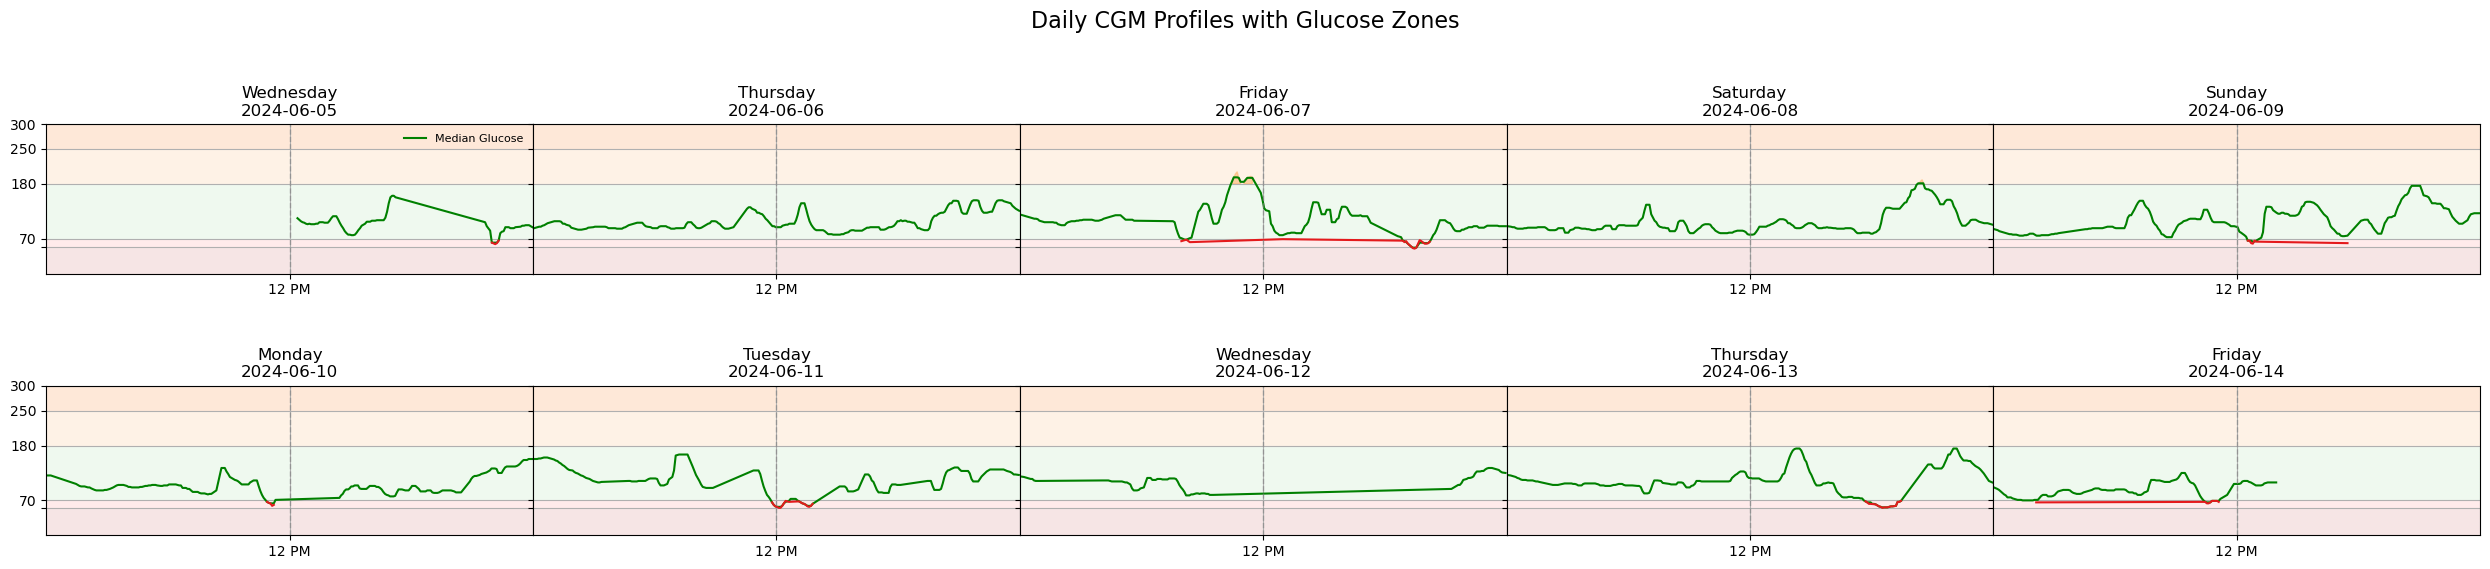

In [17]:
# 6. Daily Subplots
cols = 5
dates = sorted(cgm_plot["date"].unique())[:10]
rows = (len(dates) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 3), sharey=True)
axes = axes.flatten()
grouped = cgm_plot.groupby("date")

for i, date in enumerate(dates):
    ax = axes[i]
    day_data = grouped.get_group(date).sort_values("hour")
    add_glucose_zones(ax)

    smoothed = day_data["blood_glucose_value"].rolling(window=5, center=True, min_periods=1).median()
    ax.plot(day_data["hour"], smoothed, color="green", label="Median Glucose")

    # Fill high
    ax.fill_between(
        day_data["hour"], 180, day_data["blood_glucose_value"],
        where=day_data["blood_glucose_value"] > 180,
        color="#FDAE61", alpha=0.5
    )
    # Plot low
    low_mask = day_data["blood_glucose_value"] < 70
    ax.plot(
        day_data["hour"][low_mask],
        day_data["blood_glucose_value"][low_mask],
        color="#E41A1C", linewidth=1.5
    )

    weekday = datetime.datetime.strptime(date, "%Y-%m-%d").strftime("%A")
    ax.set_xlim(0, 24)
    ax.set_xticks([12])
    ax.set_xticklabels(["12 PM"])
    ax.set_ylim(0, 300)
    ax.set_yticks([54,70, 180, 250, 300])
    ax.set_yticklabels(["", "70", "180", "250", "300"])
    ax.set_title(f"{weekday}\n{date}")
    ax.axvline(x=12, color="gray", linestyle="--", linewidth=1, alpha=0.6)
    ax.grid(True)
    if i == 0:
        ax.legend(fontsize=8, loc="upper right", frameon=False)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

fig.suptitle("Daily CGM Profiles with Glucose Zones", fontsize=16, y=0.94)
plt.tight_layout()
plt.subplots_adjust(
    top=0.75,      # space for the title
    hspace=0.75,    # vertical space between rows (lower = tighter)
    wspace=0    # horizontal space between columns (try 0 for near-touching)
)
plt.show()

**Ambulatory Glucose Profile (AGP)** visualizes glucose trends as if they occurred in a single day.
Colored Bands (Percentile Ranges):
- Dark Green Line: Median glucose (50th percentile).
- Green Shaded Area: 25th–75th percentile range.
- Orange Shaded Area: 5th–95th percentile range.
- Target Range (70–180 mg/dL):
- Marked in green with horizontal lines at 70 mg/dL and 180 mg/dL.


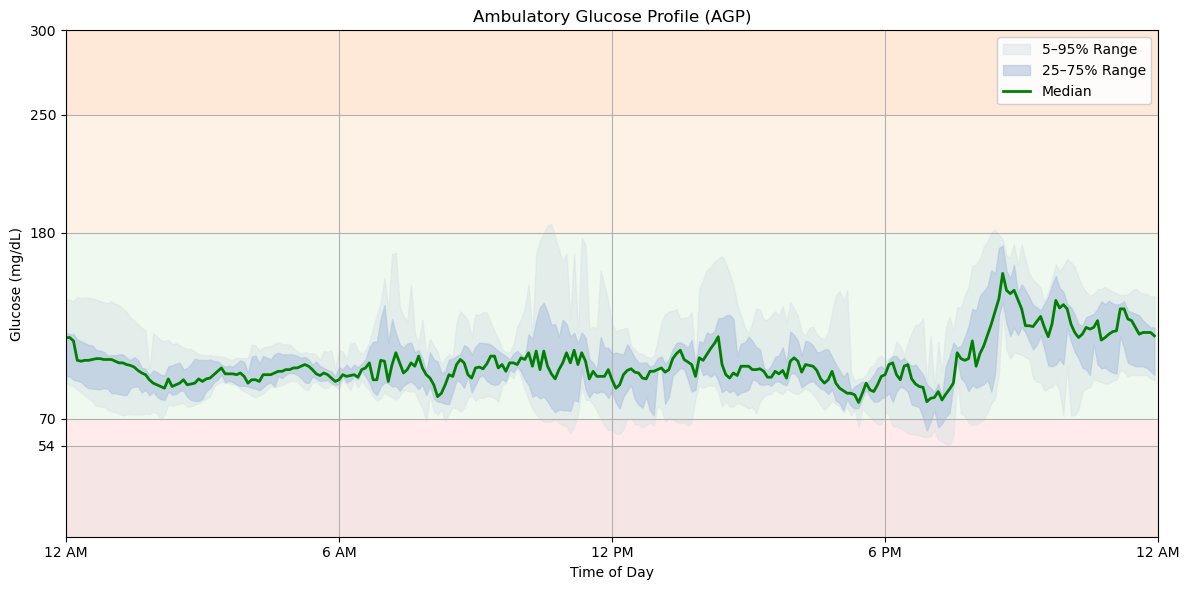

In [18]:
# 7. AGP (Ambulatory Glucose Profile)
cgm_plot["minute_of_day"] = (
    cgm_plot["effective_time_frame_date_time_local"].dt.hour * 60 +
    cgm_plot["effective_time_frame_date_time_local"].dt.minute
)
cgm_plot["time_bin"] = (cgm_plot["minute_of_day"] // 5) * 5

agp_summary = cgm_plot.groupby("time_bin")["blood_glucose_value"].quantile([0.05, 0.25, 0.5, 0.75, 0.95]).unstack()
agp_summary.columns = ["p5", "p25", "p50", "p75", "p95"]
agp_summary = agp_summary.reset_index()
agp_summary["hour"] = agp_summary["time_bin"] / 60

plt.figure(figsize=(12, 6))
add_glucose_zones(plt)
plt.fill_between(agp_summary["hour"], agp_summary["p5"], agp_summary["p95"], color="#D8E3E7", alpha=0.5, label="5–95% Range")
plt.fill_between(agp_summary["hour"], agp_summary["p25"], agp_summary["p75"], color="#B0C4DE", alpha=0.6, label="25–75% Range")
plt.plot(agp_summary["hour"], agp_summary["p50"], color="green", linewidth=2, label="Median")

plt.title("Ambulatory Glucose Profile (AGP)")
plt.xlabel("Time of Day")
plt.ylabel("Glucose (mg/dL)")
plt.xticks([0, 6, 12, 18, 24], ["12 AM", "6 AM", "12 PM", "6 PM", "12 AM"])
plt.xlim(0, 24)
plt.ylim(0, 300)
plt.yticks([54, 70, 180, 250, 300])
plt.grid(True)
plt.legend(loc="upper right", fontsize=10, frameon=True, framealpha=0.9)
plt.tight_layout()
plt.show()

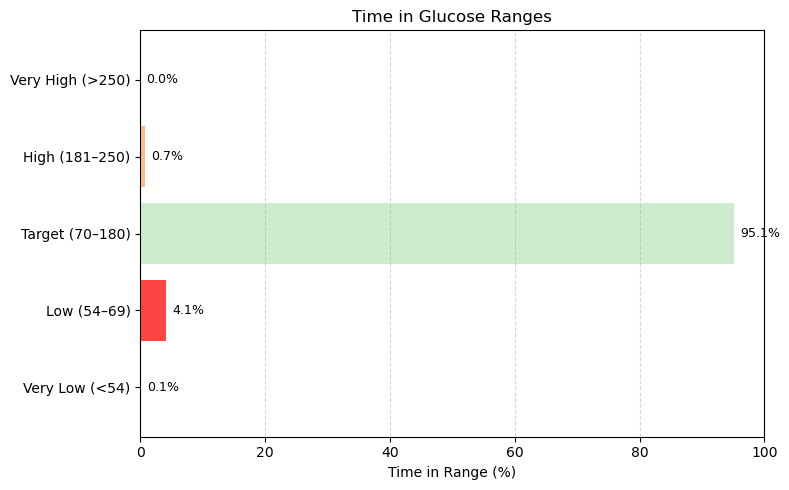

In [19]:
# Count total readings
total = len(cgm_plot)

# Compute % time in each range
tir_data = {
    "Very Low (<54)": (cgm_plot["blood_glucose_value"] < 54).sum() / total * 100,
    "Low (54–69)": ((cgm_plot["blood_glucose_value"] >= 54) & (cgm_plot["blood_glucose_value"] < 70)).sum() / total * 100,
    "Target (70–180)": ((cgm_plot["blood_glucose_value"] >= 70) & (cgm_plot["blood_glucose_value"] <= 180)).sum() / total * 100,
    "High (181–250)": ((cgm_plot["blood_glucose_value"] > 180) & (cgm_plot["blood_glucose_value"] <= 250)).sum() / total * 100,
    "Very High (>250)": (cgm_plot["blood_glucose_value"] > 250).sum() / total * 100,
}

# Plot
plt.figure(figsize=(8, 5))
tir_colors = [
    "#a00", "#f44", "#CDECCD", "#FDBE85", "#FD8D3C"
]
bars = plt.barh(list(tir_data.keys()), list(tir_data.values()), color=tir_colors)

plt.xlabel("Time in Range (%)")
plt.title("Time in Glucose Ranges")
plt.xlim(0, 100)
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Add percentage labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 1, bar.get_y() + bar.get_height()/2,
             f"{width:.1f}%", va='center', fontsize=9)

plt.tight_layout()
plt.show()

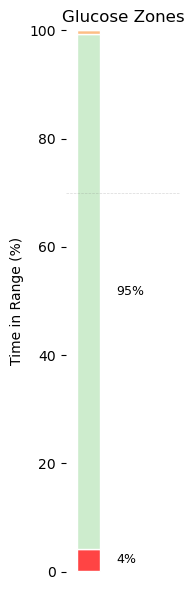

In [20]:
# Define the same time-in-range calculation
tir_data = {
    "Very Low": (cgm_plot["blood_glucose_value"] < 54).sum(),
    "Low": ((cgm_plot["blood_glucose_value"] >= 54) & (cgm_plot["blood_glucose_value"] < 70)).sum(),
    "Target": ((cgm_plot["blood_glucose_value"] >= 70) & (cgm_plot["blood_glucose_value"] <= 180)).sum(),
    "High": ((cgm_plot["blood_glucose_value"] > 180) & (cgm_plot["blood_glucose_value"] <= 250)).sum(),
    "Very High": (cgm_plot["blood_glucose_value"] > 250).sum(),
}

total = sum(tir_data.values())
tir_pct = {k: v / total * 100 for k, v in tir_data.items()}

# Colors that match your other plots
tir_colors = {
    "Very Low": "#a00",
    "Low": "#f44",
    "Target": "#CDECCD",
    "High": "#FDBE85",
    "Very High": "#FD8D3C",
}

# Plot the vertical stacked bar
plt.figure(figsize=(2, 6))

bottom = 0
for label in ["Very Low", "Low", "Target", "High", "Very High"]:
    height = tir_pct[label]
    plt.bar(0, height, bottom=bottom, color=tir_colors[label], width=0.5, edgecolor='white')
    # Add percent labels
    if height > 3:  # skip labeling tiny slivers
        plt.text(0.6, bottom + height / 2, f"{height:.0f}%", va='center', fontsize=9)
    bottom += height

# Formatting
plt.xlim(-0.5, 2)
plt.ylim(0, 100)
plt.xticks([])
plt.ylabel("Time in Range (%)")
plt.title("Glucose Zones")

# Optional: add reference lines
for y in [70, 180, 250]:  # these are just visual references, can be removed
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)

plt.box(False)
plt.tight_layout()
plt.show()

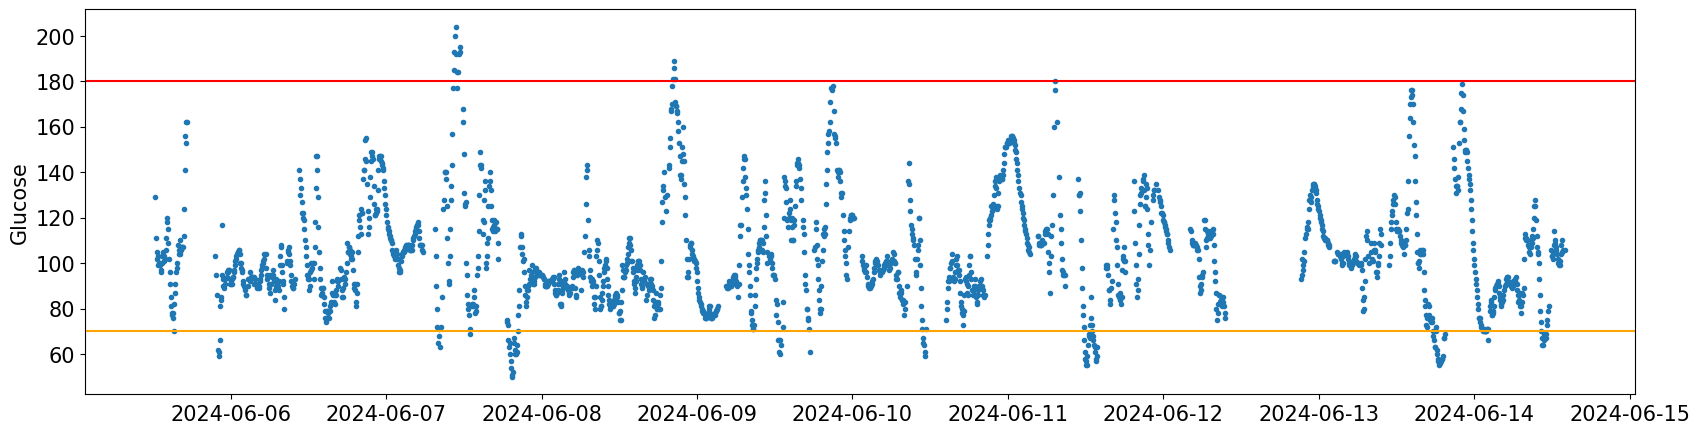

In [21]:
df['Time'] = df.effective_time_frame_date_time_local
df['Glucose'] = df.blood_glucose_value
df['Day'] = df['Time'].dt.date
cgmquantify.plotglucosebounds(df)

In [22]:
cgm.head()

,blood_glucose_value,effective_time_frame_date_time_local
0,129,2024-06-05 12:23:22
1,111,2024-06-05 12:28:22
2,105,2024-06-05 12:33:22
3,102,2024-06-05 12:38:22
4,99,2024-06-05 12:43:22


### MAGE (Mean Amplitude of Glycemic Excursions)

MAGE measures large glucose fluctuations:

In [23]:
# Calculate differences between consecutive glucose values
cgm["glucose_diff"] = cgm["blood_glucose_value"].diff().abs()

# Define a threshold for significant glucose excursions (e.g., 1 SD)
threshold = std_glucose

# Compute MAGE: Mean of all large excursions above the threshold
mage = cgm[cgm["glucose_diff"] > threshold]["glucose_diff"].mean()
print(f"Mean Amplitude of Glycemic Excursions (MAGE): {mage:.2f} mg/dL")

Mean Amplitude of Glycemic Excursions (MAGE): 37.74 mg/dL


### MODD (Mean of Daily Differences)

MODD measures day-to-day glucose fluctuations at the same time of day:

In [24]:
# Extract hour and minute from the timestamp
cgm["time_of_day"] = cgm["effective_time_frame_date_time_local"].dt.strftime("%H:%M")

# Compute the mean glucose value for each time of day across all days
mean_per_time = cgm.groupby("time_of_day")["blood_glucose_value"].mean()

# Compute MODD as the mean of absolute day-to-day differences
modd = mean_per_time.diff().abs().mean()
print(f"Mean of Daily Differences (MODD): {modd:.2f} mg/dL")

Mean of Daily Differences (MODD): 14.53 mg/dL


## Step 5: 📊 Aggregate study data across patients

If we omit the `patient_id` from the query, we will get observations for all patients in the study.
The patient is identified by the `subject_reference` column, which looks like `Patient/{patient_id}`

In [25]:
all_study_data = jh_client.list_observations_df(study_id=study_id, limit=50_000, code=CGM)
all_study_data

,resource_type,resourceType,id,meta_lastUpdated,status,subject_reference,code_coding_0_code,code_coding_0_system,modality,schema_id_name,...,external_datasheets_0_datasheet_type,external_datasheets_0_datasheet_reference,source_creation_date_time,blood_glucose_unit,blood_glucose_value,effective_time_frame_date_time,temporal_relationship_to_meal,creation_date_time_local,source_creation_date_time_local,effective_time_frame_date_time_local
0,omh:blood-glucose:4.0,Observation,103799,2025-04-17 16:45:45.625689+00:00,final,Patient/40054,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-02-03 03:42:12+00:00,MGDL,93,2024-02-03 03:42:12+00:00,unknown,2024-02-03 03:42:12,2024-02-03 03:42:12,2024-02-03 03:42:12
1,omh:blood-glucose:4.0,Observation,103800,2025-04-17 16:45:45.625689+00:00,final,Patient/40054,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-02-03 03:47:12+00:00,MGDL,93,2024-02-03 03:47:12+00:00,unknown,2024-02-03 03:47:12,2024-02-03 03:47:12,2024-02-03 03:47:12
2,omh:blood-glucose:4.0,Observation,103801,2025-04-17 16:45:45.625689+00:00,final,Patient/40054,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-02-03 03:52:12+00:00,MGDL,93,2024-02-03 03:52:12+00:00,unknown,2024-02-03 03:52:12,2024-02-03 03:52:12,2024-02-03 03:52:12
3,omh:blood-glucose:4.0,Observation,103802,2025-04-17 16:45:45.625689+00:00,final,Patient/40054,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-02-03 03:57:12+00:00,MGDL,95,2024-02-03 03:57:12+00:00,unknown,2024-02-03 03:57:12,2024-02-03 03:57:12,2024-02-03 03:57:12
4,omh:blood-glucose:4.0,Observation,103803,2025-04-17 16:45:45.625689+00:00,final,Patient/40054,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-02-03 04:02:12+00:00,MGDL,96,2024-02-03 04:02:12+00:00,unknown,2024-02-03 04:02:12,2024-02-03 04:02:12,2024-02-03 04:02:12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34885,omh:blood-glucose:4.0,Observation,111560,2025-04-17 16:45:45.625689+00:00,final,Patient/40058,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-11-06 06:33:15+00:00,MGDL,92,2024-11-06 06:33:15+00:00,unknown,2024-11-06 06:33:15,2024-11-06 06:33:15,2024-11-06 06:33:15
34886,omh:blood-glucose:4.0,Observation,111561,2025-04-17 16:45:45.625689+00:00,final,Patient/40058,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-11-06 06:38:15+00:00,MGDL,93,2024-11-06 06:38:15+00:00,unknown,2024-11-06 06:38:15,2024-11-06 06:38:15,2024-11-06 06:38:15
34887,omh:blood-glucose:4.0,Observation,111562,2025-04-17 16:45:45.625689+00:00,final,Patient/40058,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-11-06 06:43:15+00:00,MGDL,92,2024-11-06 06:43:15+00:00,unknown,2024-11-06 06:43:15,2024-11-06 06:43:15,2024-11-06 06:43:15
34888,omh:blood-glucose:4.0,Observation,111563,2025-04-17 16:45:45.625689+00:00,final,Patient/40058,omh:blood-glucose:4.0,https://w3id.org/openmhealth,self-reported,blood-glucose,...,manufacturer,Dexcom,2024-11-06 06:48:15+00:00,MGDL,92,2024-11-06 06:48:15+00:00,unknown,2024-11-06 06:48:15,2024-11-06 06:48:15,2024-11-06 06:48:15


We can remove the `Patient/` prefix in `subject_reference`, and subset the relevant data as we did before.
This time, keeping `patient_id` so we can differentiate patients.

In [26]:
all_study_data["patient_id"] = all_study_data["subject_reference"].str.replace("Patient/", "")

all_cgm = all_study_data.loc[
    :,
    [
        "patient_id",
        "blood_glucose_value",
        "effective_time_frame_date_time_local",
    ],
]
# ensure sorted by date
all_cgm = all_cgm.sort_values("effective_time_frame_date_time_local")
all_cgm.head()

,patient_id,blood_glucose_value,effective_time_frame_date_time_local
3642,40056,122,2024-01-13 12:58:17
3643,40056,123,2024-01-13 13:03:17
3644,40056,124,2024-01-13 13:08:17
3645,40056,128,2024-01-13 13:13:17
3646,40056,133,2024-01-13 13:18:17


Now we can group by patient to compare across our cohort:

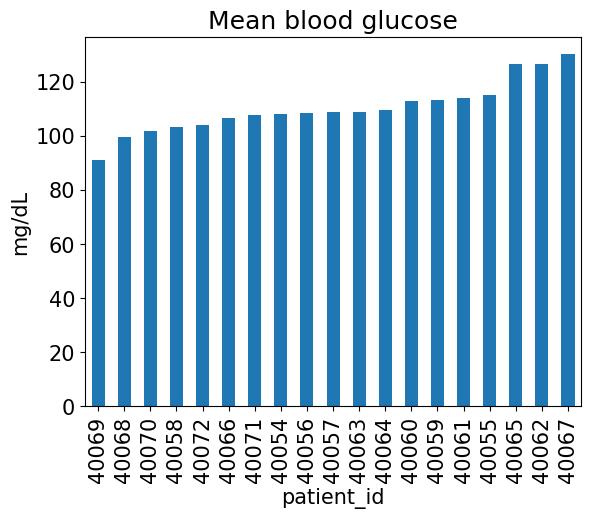

In [27]:
all_cgm.groupby("patient_id").blood_glucose_value.mean().sort_values().plot(kind="bar");
plt.title("Mean blood glucose")
plt.ylabel("mg/dL");

And again, compute our Glucose Management Indicator (GMI) from the mean:

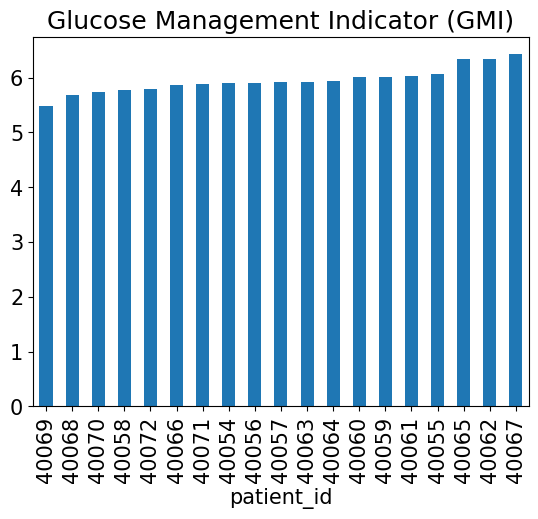

In [28]:
def compute_gmi(mean_glucose):
    return 3.31 + (0.02392 * mean_glucose)

all_cgm.groupby("patient_id").blood_glucose_value.mean().apply(compute_gmi).sort_values().plot(kind="bar")
plt.title("Glucose Management Indicator (GMI)");

We can also use this information to produce time-in-range bar for every patient in the study

In [29]:
def compute_time_in_range(df):
    tir_data = {
        "Very Low": (df["blood_glucose_value"] < 54).sum(),
        "Low": ((df["blood_glucose_value"] >= 54) & (df["blood_glucose_value"] < 70)).sum(),
        "Target": ((df["blood_glucose_value"] >= 70) & (df["blood_glucose_value"] <= 180)).sum(),
        "High": ((df["blood_glucose_value"] > 180) & (df["blood_glucose_value"] <= 250)).sum(),
        "Very High": (df["blood_glucose_value"] > 250).sum(),
    }
    return pd.Series(tir_data) * 100 / len(df)

ranges = all_cgm.groupby("patient_id").apply(compute_time_in_range, include_groups=False)
ranges

,Very Low,Low,Target,High,Very High
patient_id,,,,,
40054,0.000000,0.541712,96.912243,2.546046,0.000000
40055,0.000000,0.167038,99.554566,0.278396,0.000000
40056,0.000000,0.056085,99.775659,0.168256,0.000000
40057,0.000000,0.912507,98.067633,1.019860,0.000000
40058,0.000000,0.000000,100.000000,0.000000,0.000000
40059,0.000000,0.000000,100.000000,0.000000,0.000000
40060,0.216685,1.245937,97.128927,1.408451,0.000000
40061,0.000000,2.637363,97.087912,0.274725,0.000000
40062,0.000000,0.731982,94.256757,5.011261,0.000000


In [ ]:
ranges.plot(kind='bar', stacked=True, color=tir_colors)
plt.legend(bbox_to_anchor=(1, 1), reverse=True)
plt.ylim(0, 100)
plt.title("% time in range");

**Data Sources and Methodology:**

This tutorial uses sample CGM data from the PLOS Biology supplemental dataset: <https://doi.org/10.1371/journal.pbio.2005143.s010>

Analysis methods are based on:
- Hall, H., et al. (2018). Glucotypes reveal new patterns of glucose dysregulation. *PLOS Biology*. <https://doi.org/10.1371/journal.pbio.2005143>
- Glycemia Risk Index methodology: <https://www.diabetestechnology.org/gri/>